<a href="https://www.kaggle.com/code/carlacotas/llm-classification-finetuning?scriptVersionId=213890913" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/llm-classification-finetuning/sample_submission.csv
/kaggle/input/llm-classification-finetuning/train.csv
/kaggle/input/llm-classification-finetuning/test.csv


In [2]:
# Import libraries helpful for cleaning text data

import re     #regular expression operations
import string #simplifies working with strings
import nltk   #Natural Language Toolkit
nltk.download('stopwords') #download stopwords list from NLTK
from nltk.corpus import stopwords

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [3]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

# kaggle 'Competitions': LLM Classification Finetuning
***Finetune LLMs to Predict Human Preference using Chatbot Arena conversations***

This notebook contain a solution for the [LLM Classification Finetuning on Kaggle](http://www.kaggle.com/competitions/llm-classification-finetuning/overview)


**Main objective:** Predict which responses users will prefer in a head-to-head battle between chatbots powered by large language models(LLMs).

**Data**

train.csv

- id - A unique identifier for the row.
- model_a/b - The identity of model_a/b. Included in train.csv but not test.csv.
- prompt - The prompt that was given as an input (to both models).
- response_a/b - The response from model_a/b to the given prompt.
- winner_model_a/b/tie - Binary columns marking the judge's selection. The ground truth target column.

test.csv

- id
- prompt
- response_a/b

sample_submission.csv A submission file in the correct format.
- id
- winner_model_a/b/tie - This is what is predicted from the test set.


**Main steps**

1. [Understand the original data](#section1) <a href='#section1'></a>
2. [Data Cleaning](#section2) <a href='#section2'></a>
3. [Data Exploration](#section3) <a href='#section3'></a>
4. [Feature Engineering](#section4) <a href='#section4'></a>
5. [Model Selection and Training](#section5) <a href='#section5'></a>
6. [Model Evaluation](#section6) <a href='#section6'></a>
7. [Submission File](#section7) <a href='#section7'></a>

<a id='section1'></a>

## **1. Understand the original data**

> The first analysis is always made working with the Training set. Only after this first analysis, it comes the final step which is to make predictions based on the test set.

The first thing to do is to import the raw data.

In [4]:
# import the data
training = pd.read_csv('/kaggle/input/llm-classification-finetuning/train.csv')
test = pd.read_csv('/kaggle/input/llm-classification-finetuning/test.csv')

training['train_test'] = 1
test['train_test'] = 0
all_data = pd.concat([training,test])

print("Import Data Complete")

Import Data Complete


Then we should look at our data to get familiar with data and understand the data types, data consistency, null counts to think about how to manage that data/information

In [5]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57477 entries, 0 to 57476
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              57477 non-null  int64 
 1   model_a         57477 non-null  object
 2   model_b         57477 non-null  object
 3   prompt          57477 non-null  object
 4   response_a      57477 non-null  object
 5   response_b      57477 non-null  object
 6   winner_model_a  57477 non-null  int64 
 7   winner_model_b  57477 non-null  int64 
 8   winner_tie      57477 non-null  int64 
 9   train_test      57477 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 4.4+ MB


In [6]:
training.head(10)

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,train_test
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0,1
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0,1
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0,1
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0,1
5,292873,vicuna-13b,gpt-4-0314,"[""Construct a rap battle, in the style of Epic...","[""[Zeus]\nYo, it's the king of the gods on the...","[""(Verse 1 - Zeus)\n\nI'm the king of the gods...",0,1,0,1
6,313413,mixtral-8x7b-instruct-v0.1,vicuna-13b,"[""Why water is not used in bath tub?""]","[""Water is actually used in a bath tub. A bath...","[""Water is not used in a bath tub because it i...",1,0,0,1
7,370945,gemini-pro,claude-2.0,"[""\""Bacteria is life on Mars but a heartbeat i...","[""Dune""]","[""This quote seems to be referencing the debat...",0,1,0,1
8,441448,gpt-3.5-turbo-0613,vicuna-13b,"[""translate to russian the followig sentence ...","[""\u0411\u043e\u043b\u044c\u0448\u0438\u0435 \...","[""\u0411\u043e\u043b\u044c\u0448\u0438\u0435 \...",0,1,0,1
9,481524,gpt-4-0314,gpt-3.5-turbo-0613,"[""From now, you *always* have to talk as if yo...","[""Hewwo! OwO I'm an AI assistant, here to hewp...","[""Hewwo! I'm your new helpful assistant, owo! ...",0,1,0,1


In [7]:
training.tail(10)

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,train_test
57467,4294254797,gpt-4-1106-preview,claude-2.0,"[""can you provide a modular python code that w...","[""Certainly! Below is a modular Python example...","[""Here is a modular Python code to format SQL ...",1,0,0,1
57468,4294349169,palm-2,guanaco-33b,"[""Schreibe ein Bewerbungsanschreiben in deutsc...","[""I am trained to understand and respond only ...","[""Here is a possible Bewerbungsanschreiben in ...",0,1,0,1
57469,4294452769,gpt-4-1106-preview,openchat-3.5,"[""Old McDonald harvested 4 pumpkins this year....","[""Old McDonald originally harvested 4 pumpkins...","[""Old McDonald had 4 pumpkins initially and no...",0,0,1,1
57470,4294602932,claude-2.1,gpt-4-1106-preview,"[""I want you to act like {character} from {ser...","[""*responds in character's voice* Well hello t...","[""Of course! However, you'll need to specify w...",0,1,0,1
57471,4294633312,pplx-7b-online,gpt-4-0613,"[""abc""]","[""It seems like you're referring to the Califo...","[""Hello! It seems like you've typed \""abc.\"" H...",1,0,0,1
57472,4294656694,gpt-4-0613,claude-1,"[""A simple mnemonic for \u03c0:\n\""How I wish ...","[""Sure, let's break it down:\n\n1. \""How\"" has...","[""Here is how that mnemonic represents the dig...",1,0,0,1
57473,4294692063,claude-2.0,llama-2-13b-chat,"[""In python, implement a naive Bayes with gaus...","[""Here is an implementation of a naive Bayes c...","[""Sure! Here's an implementation of a naive Ba...",1,0,0,1
57474,4294710549,claude-1,alpaca-13b,"[""is it unethical to work on building weapons?...","[""Working on weapons technology raises some et...","[""It depends on the context. Weapons can be us...",1,0,0,1
57475,4294899228,palm-2,tulu-2-dpo-70b,"[""If a bait contains 0,0025% bromadiolon then ...","[""Bromadiolone is a rodenticide which is most ...","[""As an AI language model, I do not promote or...",0,1,0,1
57476,4294947231,gemini-pro-dev-api,gpt-4-1106-preview,"[""three kids eat three apples in three days, h...","[""27 apples""]","[""If three kids eat three apples in three days...",1,0,0,1


<a id='section2'></a>

## **2. Data Cleaning**

After we get familiar with data and understand the data types, we should look at data consistency, null counts to think about how to manage that data/information.

In [8]:
#check for duplicate id's
total_id = len(training["id"])
total_unique_id = len(training["id"].unique())

print("Total number of 'id' duplicates:")
print(total_id - total_unique_id)

Total number of 'id' duplicates:
0


In [9]:
#check for null or empty cells
nan_count = training.isna().sum().sum()
null_count = training.isnull().sum().sum()

print('Number of NaN values:', nan_count)
print('Number of null values:', null_count)

Number of NaN values: 0
Number of null values: 0


In [10]:
#check for consistency of model_a, model_b and LLMs identification
total_unique_model_a = len(training["model_a"].unique())
total_unique_model_b = len(training["model_b"].unique())

print("Total number of 'model_a' and 'model_b' unique values:")
print('model_a =', total_unique_model_a)
print('model_b =', total_unique_model_b)

LLM_a = training["model_a"].unique()
LLM_b = training["model_b"].unique()
LLM = list(set(LLM_a).intersection(set(LLM_b)))

print("total number of LLMs =", len(LLM))
print('LLMs utilized:', LLM)



Total number of 'model_a' and 'model_b' unique values:
model_a = 64
model_b = 64
total number of LLMs = 64
LLMs utilized: ['vicuna-13b', 'RWKV-4-Raven-14B', 'gpt-4-1106-preview', 'llama2-70b-steerlm-chat', 'gpt-3.5-turbo-0314', 'claude-2.1', 'gpt-4-0314', 'guanaco-33b', 'mpt-7b-chat', 'claude-1', 'gpt-3.5-turbo-1106', 'chatglm2-6b', 'oasst-pythia-12b', 'fastchat-t5-3b', 'gpt4all-13b-snoozy', 'llama-2-13b-chat', 'starling-lm-7b-alpha', 'openchat-3.5-0106', 'gpt-3.5-turbo-0613', 'dolly-v2-12b', 'gpt-4-0125-preview', 'vicuna-7b', 'stablelm-tuned-alpha-7b', 'chatglm-6b', 'wizardlm-70b', 'llama-13b', 'nous-hermes-2-mixtral-8x7b-dpo', 'dolphin-2.2.1-mistral-7b', 'wizardlm-13b', 'openhermes-2.5-mistral-7b', 'gemini-pro-dev-api', 'zephyr-7b-alpha', 'mixtral-8x7b-instruct-v0.1', 'mistral-7b-instruct-v0.2', 'palm-2', 'openchat-3.5', 'deepseek-llm-67b-chat', 'qwen-14b-chat', 'stripedhyena-nous-7b', 'solar-10.7b-instruct-v1.0', 'claude-2.0', 'gpt-3.5-turbo-0125', 'qwen1.5-4b-chat', 'codellama-34b-

In [11]:
#check for duplicate prompts -  the same prompt could have been given to more than two different LLMs
total_prompt = len(training["prompt"])
total_unique_prompt = len(training["prompt"].unique())

print("Total number of 'prompt' duplicates:")
print(total_prompt - total_unique_prompt)

#There are 57477 observations and 5743 prompt duplicates without id duplicates -> having prompt duplicates are ok to have 
#and no further data cleaning is needed to deal with prompt duplicates

Total number of 'prompt' duplicates:
5743


Now that the data was checked for duplicates, NaN and null values, and consistency, it is essential to clean cells with text data (columns _prompt_, _response_a_ and _response_b_).

In [12]:
#clean cells with text data
def preprocess_text(text):
    #convert text to lower case
    text = text.lower()
    #remove digits and special characters using regular expressions
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    #tokenize the text
    text = nltk.word_tokenize(text)
    
    return text

def remove_stopwords(text):
    #remove stopwords
    stop_words = set(stopwords.words('english'))
    text_no_stopwords = [word for word in text if word not in stop_words]

    return text_no_stopwords


def lemmatization(text):
    lemmatizer = nltk.WordNetLemmatizer()
    lemmatizer_text = [lemmatizer.lemmatize(text) for text in text]

    return lemmatizer_text


def clean_text(text):
    #convert text to lower case, remove digits and special characters using regular expressions and remove stopwords combined together
    text = preprocess_text(text)
    filtered_text = remove_stopwords(text)
    lemmatizer_text = lemmatization(filtered_text)
    clean_text = ' '.join(lemmatizer_text)

    return clean_text

training["prompt"] = training["prompt"].apply(clean_text)
training["response_a"] = training["response_a"].apply(clean_text)
training["response_b"] = training["response_b"].apply(clean_text)


print("Clean Cells with Text Data Complete")

Clean Cells with Text Data Complete


In [13]:
training.head(10)


,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,train_test
0,30192,gpt-4-1106-preview,gpt-4-0613,morally right try certain percentage female ma...,question whether morally right aim certain per...,ai dont personal belief opinion however tell q...,1,0,0,1
1,53567,koala-13b,gpt-4-0613,difference marriage license marriage certifica...,marriage license legal document allows couple ...,marriage license marriage certificate two diff...,0,1,0,1
2,65089,gpt-3.5-turbo-0613,mistral-medium,explain function calling would call function,function calling process invoking executing fu...,function calling process invoking function pro...,0,0,1,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,create test set rare category want build class...,creating test set rare category challenging ma...,building classifier rare category creating tes...,1,0,0,1
4,198779,koala-13b,gpt-3.5-turbo-0314,best way travel telaviv jerusalem car bus plane,best way travel tel aviv jerusalem depends per...,best way travel telaviv jerusalem depends pers...,0,1,0,1
5,292873,vicuna-13b,gpt-4-0314,construct rap battle style epic rap battle his...,zeusnyo king god micni control sky thunder lig...,verse zeusnnim king god ruler skiesnhere teach...,0,1,0,1
6,313413,mixtral-8x7b-instruct-v0.1,vicuna-13b,water used bath tub,water actually used bath tub bath tub specific...,water used bath tub suitable medium conducting...,1,0,0,1
7,370945,gemini-pro,claude-2.0,bacteria life mar heartbeat isnt life earth quote,dune,quote seems referencing debate around life beg...,0,1,0,1
8,441448,gpt-3.5-turbo-0613,vicuna-13b,translate russian followig sentence big landlo...,uueubucuuu uuucubuuubuuuubucuub uuufueubucuueu...,uueubucuuu uueuuuuuududuuau uduuuuuuucueuuu uu...,0,1,0,1
9,481524,gpt-4-0314,gpt-3.5-turbo-0613,always talk cute girl like use owo similar sla...,hewwo owo im ai assistant hewp question pwoble...,hewwo im new helpful assistant owo call assist...,0,1,0,1


In [14]:
training.tail(10)

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,train_test
57467,4294254797,gpt-4-1106-preview,claude-2.0,provide modular python code easy add additiona...,certainly modular python example format sql co...,modular python code format sql codennpythonnim...,1,0,0,1
57468,4294349169,palm-2,guanaco-33b,schreibe ein bewerbungsanschreiben deutsch fuf...,trained understand respond subset language tim...,possible bewerbungsanschreiben deutsch job adv...,0,1,0,1
57469,4294452769,gpt-4-1106-preview,openchat-3.5,old mcdonald harvested pumpkin year neighbour ...,old mcdonald originally harvested pumpkin neig...,old mcdonald pumpkin initially given pumpkin n...,0,0,1,1
57470,4294602932,claude-2.1,gpt-4-1106-preview,want act like character series want respond an...,responds character voice well hello brings tal...,course however youll need specify character se...,0,1,0,1
57471,4294633312,pplx-7b-online,gpt-4-0613,abc,seems like youre referring california abc lice...,hello seems like youve typed abc may assist,1,0,0,1
57472,4294656694,gpt-4-0613,claude-1,simple mnemonic ucnhow wish could enumerate pi...,sure let break downnn lettersn lettern wish le...,mnemonic represents digit ucnnhow letter uc ni...,1,0,0,1
57473,4294692063,claude-2.0,llama-2-13b-chat,python implement naive bayes gaussian mixture ...,implementation naive bayes classifier gaussian...,sure here implementation naive bayes classifie...,1,0,0,1
57474,4294710549,claude-1,alpaca-13b,unethical work building weaponsare deterrent n...,working weapon technology raise ethical questi...,depends context weapon used defensive purpose ...,1,0,0,1
57475,4294899228,palm-2,tulu-2-dpo-70b,bait contains bromadiolon much adult rat need ...,bromadiolone rodenticide often used bait secon...,ai language model promote condone use poison h...,0,1,0,1
57476,4294947231,gemini-pro-dev-api,gpt-4-1106-preview,three kid eat three apple three day many apple...,apple,three kid eat three apple three day kid eats o...,1,0,0,1


Now, the raw text in columns _prompt_, _response_a_ and _response_b_ are clean and ready for the next steps. 

<a id='section3'></a>

## **3. Data Exploration**

The next thing to do it to get to know data more detailed and examining it to find initial patterns and interesting points

model a: model_a
gpt-4-1106-preview          3678
gpt-3.5-turbo-0613          3553
gpt-4-0613                  3099
claude-2.1                  2859
gpt-4-0314                  2087
                            ... 
falcon-180b-chat             145
openchat-3.5-0106            108
qwen1.5-7b-chat              106
qwen1.5-4b-chat              100
mistral-7b-instruct-v0.2      54
Name: count, Length: 64, dtype: int64
-----
Matplotlib barchart, model a:


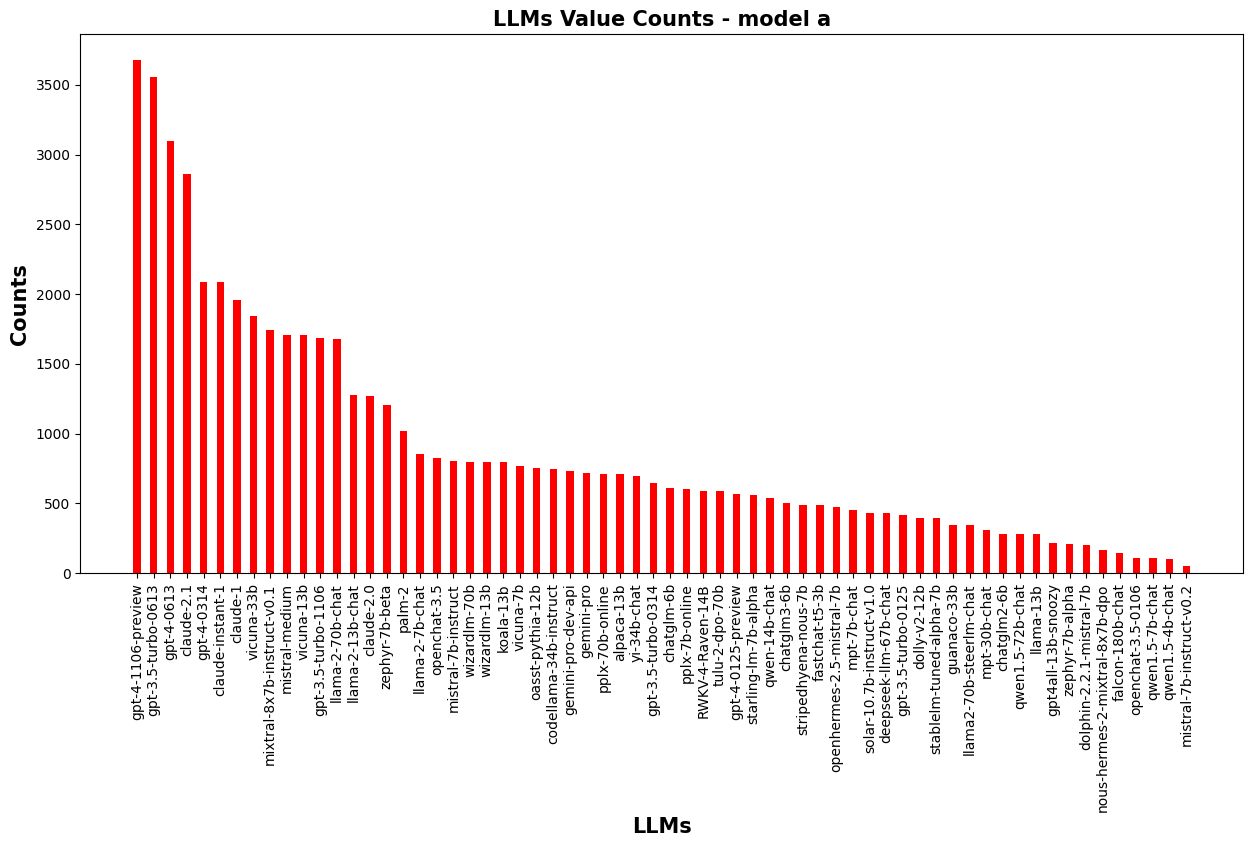

In [15]:
#barchart - model a
result_model_a = training["model_a"].value_counts()
print("model a:", result_model_a)

## Matplotlib barchart:
print("-----")
print("Matplotlib barchart, model a:")
  
barWidth = 0.45
plt.figure(figsize=(15, 7))

plt.bar(result_model_a.index, result_model_a.values, barWidth, color='r')

plt.ylabel('Counts', fontweight ='bold', fontsize = 15)
plt.xlabel('LLMs', fontweight ='bold', fontsize = 15)

plt.xticks(rotation=90)
plt.title('LLMs Value Counts - model a', fontweight ='bold', fontsize = 15)


plt.show()

model b: model_b
gpt-4-1106-preview          3709
gpt-3.5-turbo-0613          3530
gpt-4-0613                  3066
claude-2.1                  2724
claude-instant-1            2051
                            ... 
falcon-180b-chat             141
openchat-3.5-0106            136
qwen1.5-7b-chat              102
qwen1.5-4b-chat              100
mistral-7b-instruct-v0.2      46
Name: count, Length: 64, dtype: int64
-----
Matplotlib barchart, model b:


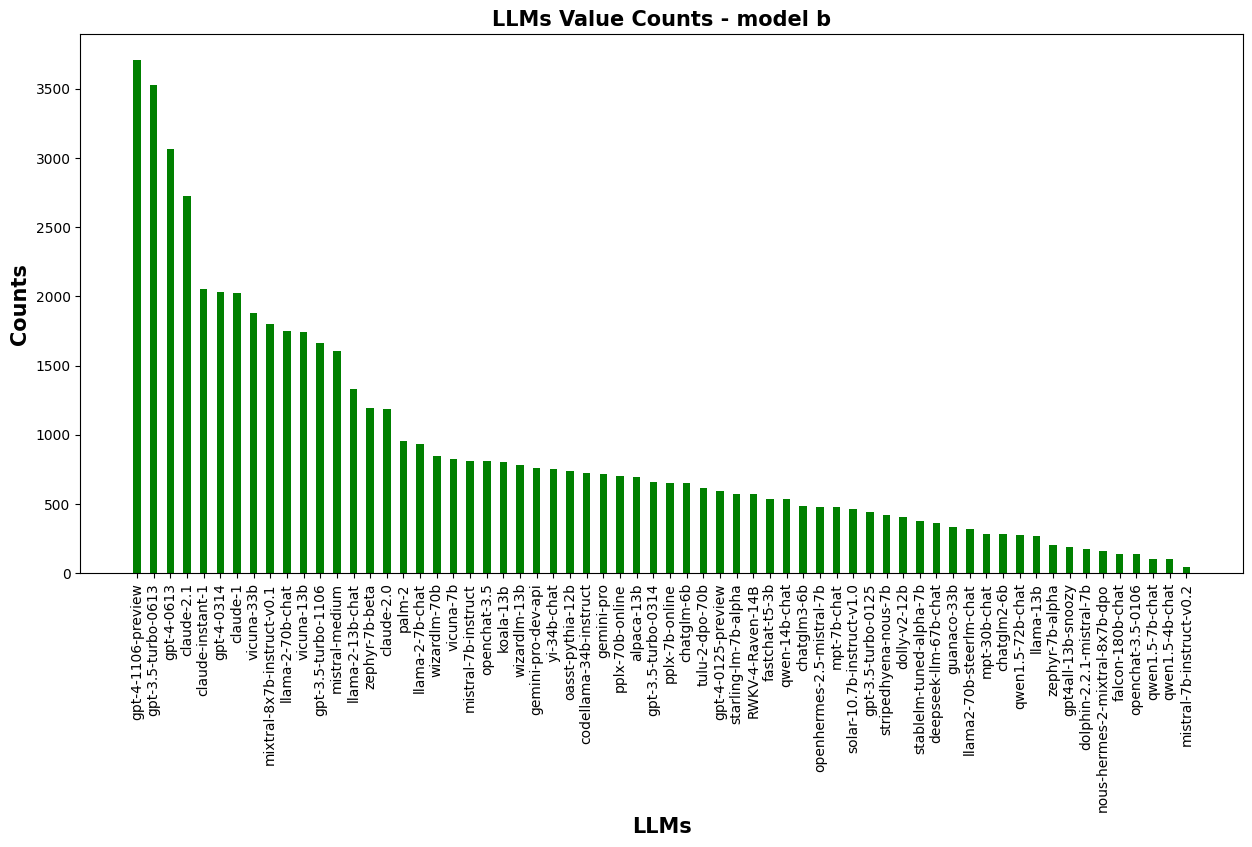

In [16]:
#barchart - model b
result_model_b = training["model_b"].value_counts()
print("model b:", result_model_b)

## Matplotlib barchart:
print("-----")
print("Matplotlib barchart, model b:")
  
barWidth = 0.45
plt.figure(figsize=(15, 7))

plt.bar(result_model_b.index, result_model_b.values, barWidth, color='g')

plt.ylabel('Counts', fontweight ='bold', fontsize = 15)
plt.xlabel('LLMs', fontweight ='bold', fontsize = 15)

plt.xticks(rotation=90)
plt.title('LLMs Value Counts - model b', fontweight ='bold', fontsize = 15)


plt.show()

model winner: winner_model
model a       20064
model b       19652
winner tie    17761
Name: count, dtype: int64
-----
Matplotlib barchart, model winner:


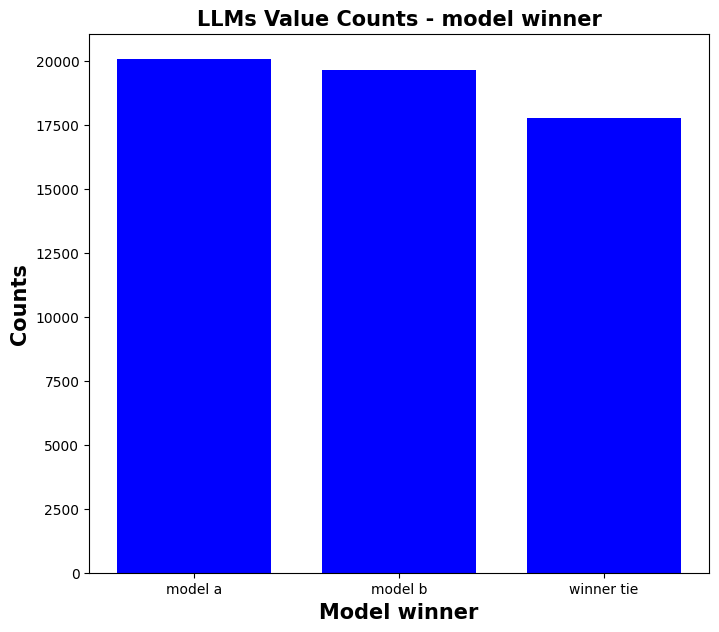

In [17]:
#barchart - model winner: winner model a, winner model b or winner tie
def which_winner(value):
    if  value["winner_model_a"] == 1:
         #winner model a
         value["winner_model_b"] = 0
         value["winner_tie"] = 0
         return 0
    elif value["winner_model_b"] == 1:
         #winner model b
         return 1
    elif value["winner_tie"] == 1:
         #winner tie
         return 2
    return None

training["winner"] = training.apply(which_winner, axis=1)

training["winner_model"] = training["winner"].astype(str)
training.loc[training["winner_model"] == "0", "winner_model"] = "model a"
training.loc[training["winner_model"] == "1", "winner_model"] = "model b"
training.loc[training["winner_model"] == "2", "winner_model"] = "winner tie"

result_model_winner = training["winner_model"].value_counts()
print("model winner:", result_model_winner)

print("-----")
print("Matplotlib barchart, model winner:")

barWidth = 0.75
plt.figure(figsize=(8, 7))

plt.bar(result_model_winner.index, result_model_winner.values, barWidth, color='b')

plt.ylabel('Counts', fontweight ='bold', fontsize = 15)
plt.xlabel('Model winner', fontweight ='bold', fontsize = 15)

plt.title('LLMs Value Counts - model winner', fontweight ='bold', fontsize = 15)


plt.show()

<a id='section4'></a>

## **4. Feature Engineering**

After cleaning the raw data and understanding it more cleary, the next step is extracting meaningful information from the data to make it usable for machine learning models.

In [18]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57477 entries, 0 to 57476
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              57477 non-null  int64 
 1   model_a         57477 non-null  object
 2   model_b         57477 non-null  object
 3   prompt          57477 non-null  object
 4   response_a      57477 non-null  object
 5   response_b      57477 non-null  object
 6   winner_model_a  57477 non-null  int64 
 7   winner_model_b  57477 non-null  int64 
 8   winner_tie      57477 non-null  int64 
 9   train_test      57477 non-null  int64 
 10  winner          57477 non-null  int64 
 11  winner_model    57477 non-null  object
dtypes: int64(6), object(6)
memory usage: 5.3+ MB


In [19]:
#transform text data into numerical form
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features = 150) #without max_features it crashes due to memory limit
vectorizer_prompt = vectorizer.fit_transform(training["prompt"])
print(vectorizer.idf_)
print(vectorizer.get_feature_names_out())
vectorizer_response_a = vectorizer.fit_transform(training["response_a"])
print(vectorizer.idf_)
print(vectorizer.get_feature_names_out())
vectorizer_response_b = vectorizer.fit_transform(training["response_b"])
print(vectorizer.idf_)
print(vectorizer.get_feature_names_out())



temp_prompt = vectorizer.transform(training["prompt"])
temp_response_a = vectorizer.fit_transform(training["response_a"])
temp_response_b = vectorizer.fit_transform(training["response_b"])

print("vectorizer representation for 'prompt':\n", temp_prompt.toarray())
print("vectorizer representation for 'response a':\n", temp_response_a.toarray())
print("vectorizer representation for 'response b':\n", temp_response_b.toarray())

print("Number of elements for the vectorizer representation for 'prompt':\n", temp_prompt.shape)
print("Number of elements for the vectorizer representation for 'response a':\n", temp_response_a.shape)
print("Number of elements for the vectorizer representation for 'response b':\n", temp_response_b.shape)


[4.96706112 5.08186147 4.89525358 4.79521086 4.27116038 5.00070915
 4.08555976 5.05842688 4.66886466 4.19783836 4.78443324 5.37298589
 5.20805608 5.01314355 4.64860739 4.27253621 4.85337142 5.97019613
 5.19758478 5.08806625 5.15011824 4.26430947 4.27116038 4.58703952
 4.57952539 4.8403313  4.7235384  4.33894277 4.84764543 4.79211967
 4.82905903 4.34435218 3.96418802 5.13152831 4.70710359 4.19401264
 3.89012822 4.91774588 4.57021145 4.85913038 4.26385441 3.76465204
 4.78061206 4.65329751 4.50154826 4.44326846 4.95700159 4.79986564
 5.00356494 4.72642441 5.58583776 5.01410648 4.75426503 5.34711651
 6.36073559 5.23652775 4.30851299 4.74538924 4.99313336 4.87409325
 5.14351755 5.24014439 4.80454219 3.7082764  5.04145194 4.25119601
 4.66478025 4.94524207 5.02476033 3.60307251 4.9790816  4.08062335
 4.96798066 4.78519923 4.61314733 4.80610591 4.54518725 4.23559507
 4.05778019 4.9081681  4.22154126 4.85501345 5.54079261 4.37692835
 4.8599558  3.53957718 5.03454515 5.15454302 5.0199036  4.5343

In [20]:
#selecting the prediction target
train_y = training["winner"].values

#choosing "features"
train_X = np.concatenate((temp_prompt.toarray(), temp_response_a.toarray(), temp_response_b.toarray()), axis=1)

print("Selecting The Prediction Target and Choosing Features Complete")

Selecting The Prediction Target and Choosing Features Complete


<a id='section5'></a>

## **5. Model Selection and Training**

The next step is the model selection and predictions. I will use data science model **Logistic Regression** to predict the outcome of the winner model, because as input features we have *temp_prompt*, *temp_response_a* and *temp_response_b* and corresponding labels _winner_ (0 for winner model a, 1 for winner model b, and 2 for winner tie). Moreover, Logistic Regression predicts the probability for each target class as requested for the Submission File.

In [21]:
#use Logistic Regression
from sklearn.linear_model import LogisticRegression
from datetime import datetime

#record start time to calculate the execution time
start = datetime.now()

#Logistic Regression
model = LogisticRegression(max_iter=500, multi_class='multinomial', solver='saga') #For large datasets the “saga” solver is usually faster [scikit-learn documentation]
model.fit(train_X, train_y)

#record end time
end = datetime.now()
 
#calculate the execution time
execution_time = (end - start).total_seconds() / 60
print(f"The time of execution is: {execution_time} minutes")


print("Model Training Complete")

 

#Note: model = LogisticRegression() without futher improvements is giving a ConvergenceWarning:
#/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
#STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
#Increase the number of iterations (max_iter) or scale the data as shown in:
#    https://scikit-learn.org/stable/modules/preprocessing.html
#Please also refer to the documentation for alternative solver options:
#    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

The time of execution is: 0.31123360000000005 minutes
Model Training Complete


<a id='section6'></a>

## **6. Model Evaluation**

In this step, the Logistic Regression model trained is evaluated to check how it performs to estimate the winner model (winner model a, winner model b or winner tie).

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score

#split into validation and training data
train_X_train, train_X_val, train_y_train, train_y_val = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

#record start time to calculate the execution time
start = datetime.now()

#think about results - comparing predictions (value_y_predict) to the actual winner model (train_y_val)
value_y_predict = model.predict(train_X_val)
print('Model winner prediction', value_y_predict)
print('Model winner real value', train_y_val)

value_y_probabilities = model.predict_proba(train_X_val)
print('Model winner prediction, probability', value_y_probabilities) #winner model a | winner model b | winner tie

#confusion matrix
cm = confusion_matrix(train_y_val, value_y_predict)
print("Confusion Matrix:\n", cm)

#model accuracy
score = model.score(train_X_val, train_y_val)
print('Model Accuracy Score', score)

#macro and micro averaged Precision and Recall
macro_precision = precision_score(train_y_val, value_y_predict, average='macro') #calculate precision for all classes individually and then average them
macro_recall = recall_score(train_y_val, value_y_predict, average='macro')
micro_precision = precision_score(train_y_val, value_y_predict, average='micro') #calculate class wise true positive and false positive and then use that to calculate overall precision
micro_recall = recall_score(train_y_val, value_y_predict, average='micro')
print("Macro Precision:", macro_precision)
print("Macro Recall:", macro_recall)
print("Micro Precision:", micro_precision)
print("Micro Recall:", micro_recall)

#record end time
end = datetime.now()
 
#calculate the execution time
execution_time = (end - start).total_seconds()
print(f"The time of execution is: {execution_time} seconds")


Model winner prediction [1 1 2 ... 0 1 0]
Model winner real value [0 0 2 ... 1 0 0]
Model winner prediction, probability [[0.29130548 0.4686674  0.24002712]
 [0.28375996 0.42613062 0.29010942]
 [0.25443333 0.30182006 0.44374661]
 ...
 [0.36987621 0.36878895 0.26133484]
 [0.32429954 0.34328797 0.33241249]
 [0.36408068 0.33347058 0.30244874]]
Confusion Matrix:
 [[2099 1237  694]
 [1316 1937  676]
 [1273 1152 1112]]
Model Accuracy Score 0.44780793319415446
Macro Precision: 0.44784081246026886
Macro Recall: 0.44274505420470317
Micro Precision: 0.44780793319415446
Micro Recall: 0.44780793319415446
The time of execution is: 0.115646 seconds


In [23]:
#model log loss - https://www.kaggle.com/competitions/llm-classification-finetuning/discussion/552103
from sklearn.metrics import log_loss

model_log_loss = log_loss(train_y_val, value_y_probabilities)

print('Model Log loss:', model_log_loss) 

# Number of classes = 3 : Logloss = - log(1/3) = 1.10
# Model Log loss: 1.05, model prediction is considered good for this project

Model Log loss: 1.0549481981727349


<a id='section7'></a>

## **7. Submission File**

The last step is to generate a CSV file with model predictions on test data to submit to the competition.

In [24]:
#clean cells with text data
test["prompt"] = test["prompt"].apply(clean_text)
test["response_a"] = test["response_a"].apply(clean_text)
test["response_b"] = test["response_b"].apply(clean_text)


print("Clean Cells with Text Data Complete")

Clean Cells with Text Data Complete


In [25]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          3 non-null      int64 
 1   prompt      3 non-null      object
 2   response_a  3 non-null      object
 3   response_b  3 non-null      object
 4   train_test  3 non-null      int64 
dtypes: int64(2), object(3)
memory usage: 248.0+ bytes


In [26]:
#transform text data into numerical form

vectorizer = TfidfVectorizer(max_features = 150) #without max_features it crashes due to memory limit
vectorizer_prompt = vectorizer.fit_transform(test["prompt"])
print(vectorizer.idf_)
print(vectorizer.get_feature_names_out())
vectorizer_test_response_a = vectorizer.fit_transform(test["response_a"])
print(vectorizer.idf_)
print(vectorizer.get_feature_names_out())
vectorizer_test_response_b = vectorizer.fit_transform(test["response_b"])
print(vectorizer.idf_)
print(vectorizer.get_feature_names_out())



temp_test_prompt = vectorizer.transform(test["prompt"])
temp_test_response_a = vectorizer.fit_transform(test["response_a"])
temp_test_response_b = vectorizer.fit_transform(test["response_b"])

print("vectorizer representation for 'prompt':\n", temp_test_prompt.toarray())
print("vectorizer representation for 'response a':\n", temp_test_response_a.toarray())
print("vectorizer representation for 'response b':\n", temp_test_response_b.toarray())

print("Number of elements for the vectorizer representation for 'prompt':\n", temp_test_prompt.shape)
print("Number of elements for the vectorizer representation for 'response a':\n", temp_test_response_a.shape)
print("Number of elements for the vectorizer representation for 'response b':\n", temp_test_response_b.shape)

[1.69314718 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718
 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718
 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718
 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718
 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718
 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718
 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718
 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718
 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718
 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718
 1.69314718 1.69314718 1.69314718 1.69314718]
['adult' 'anybody' 'anything' 'ate' 'belief' 'blue' 'care'
 'classification' 'debate' 'definition' 'dont' 'example' 'extremely'
 'female' 'find' 'finetune' 'finetuning' 'fluid' 'full' 'gamete' 'gender'
 'get' 'goddy' 'ground' 'head' 'heated' 'hehim' 'helping' 'human' 'hung'
 'imagene

In [27]:
#model prediction
test_X = np.concatenate((temp_test_prompt.toarray(), temp_test_response_a.toarray(), temp_test_response_b.toarray()), axis=1)
value_test_y_probabilities = model.predict_proba(test_X)
print('Model winner prediction, probability', value_test_y_probabilities) #winner model a | winner model b | winner tie

Model winner prediction, probability [[0.32009113 0.35567085 0.32423802]
 [0.45514224 0.32546355 0.2193942 ]
 [0.36053184 0.44520509 0.19426306]]


In [28]:
output = pd.DataFrame({'id': test.id,
                        'winner_model_a': value_test_y_probabilities[:, 0],
                        'winner_model_b': value_test_y_probabilities[:, 1],
                        'winner_tie': value_test_y_probabilities[:, 2]})
output.to_csv('submission.csv', index=False)